# Lognormal density-split model vs. AbacusSummit dark matter simulations in redshift space

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit.corr_func_utils import get_split_poles
from densitysplit.lognormal_model import *

# to automatically reload imported modules when executing cell
%load_ext autoreload
%autoreload 2

setup_logging()
    
plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

plots_dir = '/feynman/home/dphp/mp270220/plots/densitysplit'

2024-06-13 09:48:21.109573: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rhel-8.x86_64/gnu9/hdf5/1.10.8/lib:/opt/rhel-8.x86_64/modulefiles/gsl/26/lib:/datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-06-13 09:48:21.109622: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Global parameters

In [2]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
cosmology=fiducial.AbacusSummitBase()
z = 0.8
nbar = 0.0034

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

# Legendre multipoles
ells = [0, 2, 4]
nells = len(ells)

## Mock $\delta_R$

In [3]:
density_dir = '/feynman/work/dphp/mp270220/outputs/density/'
simname = 'AbacusSummit_2Gpc_z{:.3f}_ph0{{:02d}}_downsampled_particles_nbar{:.4f}'.format(z, nbar)

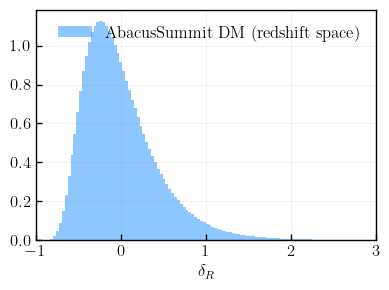

In [4]:
# halos
density_fn = simname.format(0)+'_cellsize{:d}_resampler{}_delta_R_RSD'.format(cellsize, resampler)
sim0_delta_R = np.load(os.path.join(density_dir, density_fn+'.npy'))

plt.figure(figsize = (4, 3))
pdf_sim0 = plt.hist(sim0_delta_R, bins=200, density=True, color='C0', alpha=0.5, label='AbacusSummit DM (redshift space)')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.savefig(os.path.join(plots_dir, density_fn+'.pdf'), dpi=500)
plt.show()

### Lognormal model for $\delta_R$

[000004.18]  06-13 09:48  LognormalDensityModel        INFO     Initializing LognormalDensityModel
[000004.74]  06-13 09:48  LognormalDensityModel        INFO     Computing sigma, delta0 from the second and third order moments of the density sample.
[000006.27]  06-13 09:48  LognormalDensityModel        INFO     Seting sigma to 0.404, delta0 to 1.046.


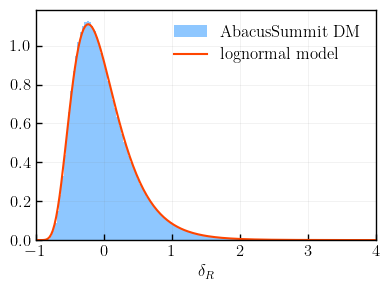

In [5]:
model = LognormalDensityModel()

delta = np.linspace(-1, 4, 200)

plt.figure(figsize = (4, 3))
plt.hist(sim0_delta_R, bins=200, density=True, color='C0', alpha=0.5, label='AbacusSummit DM')

sigma, delta0 = model.get_params_from_moments(sample=sim0_delta_R)
plt.plot(delta, model.density(delta), color='C1', label='lognormal model')

plt.xlabel(r'$\delta_R$')
plt.legend()
plt.xlim(-1, 4)
#plt.yscale('log')
#plt.ylim((1e-5, 2))
plt.savefig(os.path.join(plots_dir, density_fn+'_lognormalmodel.pdf'), dpi=500)
plt.show()

## Lognormal model for density splits

In [55]:
nsplits = 3

densitysplitsmodel = LognormalDensitySplitModel(model, nsplits=nsplits, density_bins=np.array([-1., -0.23633639,  0.10123832, np.inf]))

[003039.43]  06-13 10:39  LognormalDensityModel        INFO     Initializing LognormalDensitySplitsModel with 3 density splits


### Check smoothed 2PCF

In [56]:
# Two-point correlation function measured from 1 AbacusSummit dark matter (DM) simulation
xi_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xi_fn = simname.format(0)+'_cellsize{:d}_resampler{}_xi_R_RSD'.format(cellsize, resampler)
xi = np.load(os.path.join(xi_dir, xi_fn+'.npy'), allow_pickle=True).item()
mu_edges = xi.edges[1]
s, xiells = xi.get_corr(ells=ells, return_sep=True)

[003041.09]  06-13 10:39  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


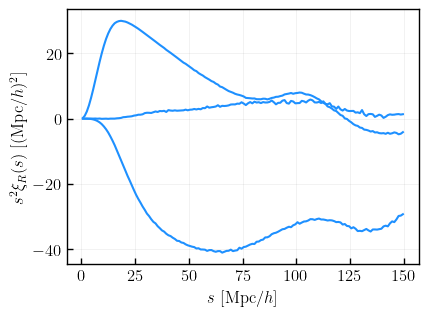

In [57]:
plt.figure(figsize = (4, 3))

for ill, ell in enumerate(ells):
    plt.plot(s, s**2 * xiells[ill], color='C0')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig(os.path.join(plots_dir, xi_fn+'.pdf'), dpi=500)
plt.show()

## Lognormal model for density splits

In [58]:
mu = (mu_edges[1:]+mu_edges[:-1])/2.
densitysplits = densitysplitsmodel.compute_dsplits(rsd=True, xiR=xi(), sep=s, mu=mu)

[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Computing lognormal density split model.
[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Setting delta0 to 1.046.
[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Setting delta0 to 1.046.
[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Setting delta0 to 1.046.
[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Setting delta0 to 1.046.
[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Setting delta0 to 1.046.
[003041.76]  06-13 10:39  LognormalDensityModel        INFO     Setting delta0 to 1.046.


In [59]:
# Density-split cross-correlation functions measured from 25 AbacusSummit DM simulations
xi_fn = simname+'_cellsize{:d}_resampler{}_{}splits_randoms_size4_RH_CCF_RSD'.format(cellsize, resampler, nsplits)
nmocks = 25
split_xi_list = [np.load(os.path.join(xi_dir, xi_fn.format(i)+'.npy'), allow_pickle=True).item()['rh'] for i in range(nmocks)]
split_xi, cov = get_split_poles(split_xi_list, ells=ells, nsplits=nsplits)
std = np.array_split(np.array(np.array_split(np.diag(cov)**0.5, nells)), nsplits, axis=1)#/np.sqrt(nmocks)
s, _, = split_xi_list[0][0].get_corr(ells=ells, return_sep=True)

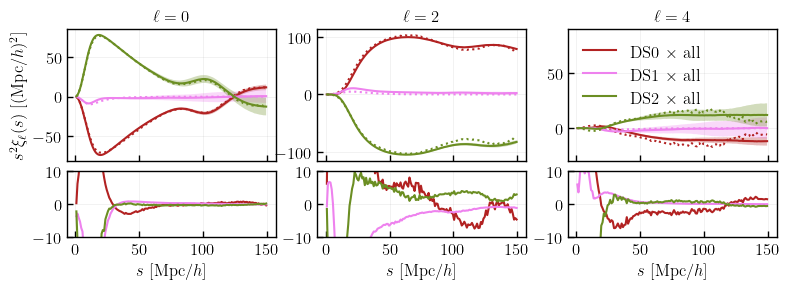

In [60]:
plt.rcParams["figure.autolayout"] = False
fig, axes = plt.subplots(2, 3, figsize=(8, 3), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})
colors = ['firebrick', 'violet', 'olivedrab']

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        axes[0][ill].plot(s, s**2 * split_xi[ds][ill], color=colors[ds], label=r'DS{} $\times$ all'.format(ds))
        axes[0][ill].fill_between(s, s**2 * (split_xi[ds][ill] - std[ds][ill]), s**2 * (split_xi[ds][ill] + std[ds][ill]), facecolor=colors[ds], alpha=0.3)
        axes[0][ill].plot(densitysplitsmodel.sep, densitysplitsmodel.sep**2 * densitysplits[ds][ill], ls=':', color=colors[ds])
        
        diff = densitysplits[ds][ill].ravel() - split_xi[ds][ill]
        axes[1][ill].plot(s, diff/std[ds][ill], color=colors[ds])
        #axes[1][ill].fill_between(s, s**2 * (diff - std[ds][ill]), s**2 * (diff + std[ds][ill]), facecolor=colors[ds], alpha=0.3)

        axes[1][ill].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
        axes[0][ill].set_title(r'$\ell = {}$'.format(ell))
        axes[1][ill].set_ylim(-10, 10)    

axes[0][2].set_ylim(-30, 90)    
axes[0][0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0][2].legend()
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig(os.path.join(plots_dir, xi_fn+'_lognormalmodel.pdf'), dpi=500)
plt.show()